In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
from bs4 import BeautifulSoup
import numpy as np
import requests
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [2]:
file_paths = [
    'mpd.slice.15000-15999.json',
]

all_data = []

for file_path in file_paths:
    with open(file_path, 'r') as file:
        data = json.load(file)
        for playlist in data['playlists']:
            playlist_name = playlist['name']
            for track in playlist['tracks']:
                all_data.append({
                    "playlist_name": playlist_name,
                    "position_in_playlist": track["pos"],
                    "track_id": track['track_uri'],
                    "track_name": track['track_name'],
                    "artist_name": track['artist_name'],
                    "duration_ms": track['duration_ms'],
                    "album_name": track['album_name']
                })
                # Add and remove for DBSCAN
                if len(all_data) >= 1000:
                    break
            if len(all_data) >= 1000:
                break
        if len(all_data) >= 1000:
            break
df = pd.DataFrame(all_data)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   playlist_name         1000 non-null   object
 1   position_in_playlist  1000 non-null   int64 
 2   track_id              1000 non-null   object
 3   track_name            1000 non-null   object
 4   artist_name           1000 non-null   object
 5   duration_ms           1000 non-null   int64 
 6   album_name            1000 non-null   object
dtypes: int64(2), object(5)
memory usage: 54.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   playlist_name         1000 non-null   object
 1   position_in_playlist  1000 non-null   int64 
 2   track_id              1000 non-null   object
 3   track_name            1000 non-nul

In [4]:
track_counts = df.groupby(['track_id', 'track_name', 'artist_name']).size().reset_index(name='count')

In [5]:
min_count = track_counts['count'].min()
max_count = track_counts['count'].max()
track_counts['popularity_score'] = (
    ((track_counts['count'] - min_count) / (max_count - min_count) * 9 + 1
).astype(int))

In [6]:
df_with_popularity = df.merge(
    track_counts[['track_id', 'popularity_score']],
    on='track_id',
    how='left'
)

# Popularity Score

## What Does the Score Tell You?
#### High Popularity Score (8-10):

#### Tracks with high scores are included in many playlists, indicating they are widely popular or well-liked.

#### Medium Popularity Score (4-7):

#### Tracks with medium scores are moderately popular and appear in a reasonable number of playlists.

#### Low Popularity Score (1-3):

#### Tracks with low scores are less popular and appear in only a few playlists.

In [7]:
df_with_popularity['popularity_score']

0      1
1      1
2      1
3      1
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: popularity_score, Length: 1000, dtype: int32

0      1
1      1
2      1
3      1
4      1
      ..
995    1
996    1
997    1
998    1
999    1
Name: popularity_score, Length: 1000, dtype: int32

In [8]:
df_with_popularity[df_with_popularity['popularity_score'] == 1]

,playlist_name,position_in_playlist,track_id,track_name,artist_name,duration_ms,album_name,popularity_score
0,Wedding Music,0,spotify:track:2rb4cO7RczQFSvpjTJ4C2P,Always Forever,Phil Wickham,281880,Phil Wickham,1
1,Wedding Music,1,spotify:track:017nSBNU2XHwMV0NCWZCqg,Divine Romance,Phil Wickham,298026,Phil Wickham,1
2,Wedding Music,2,spotify:track:0W5TB5VNs0J16suh3r67P1,Messiah / You're Beautiful,Phil Wickham,293720,Cannons,1
3,Wedding Music,3,spotify:track:1gBnG1MiTNBBVzmuwP7Wii,Love Is Not A Fight,Warren Barfield,222986,Worth Fighting For,1
4,Wedding Music,4,spotify:track:0b99xsUKkETGwZGzpX987r,When I Say I Do,Matthew West,246000,Hold You Up EP,1
...,...,...,...,...,...,...,...,...
995,house/edm,30,spotify:track:6GX1zjEDqeI6ogBtkFjleM,Perfect - Matoma Remix,One Direction,223826,Perfect - EP,1
996,house/edm,31,spotify:track:1bYuKo7Ph4qS5Klw9zzD74,Last Night Of Our Lives - Radio Edit,Manse,181500,Last Night Of Our Lives,1
997,house/edm,32,spotify:track:0tICYNayWWhH9GPeFrfjfD,This Girl (Kungs Vs. Cookin' On 3 Burners) - K...,Kungs,195546,Layers,1
998,house/edm,33,spotify:track:0NF4I7fY4eRKpDA6fPJkZT,Tell Me,Kaaze,173906,Tell Me,1


,playlist_name,position_in_playlist,track_id,track_name,artist_name,duration_ms,album_name,popularity_score
0,Wedding Music,0,spotify:track:2rb4cO7RczQFSvpjTJ4C2P,Always Forever,Phil Wickham,281880,Phil Wickham,1
1,Wedding Music,1,spotify:track:017nSBNU2XHwMV0NCWZCqg,Divine Romance,Phil Wickham,298026,Phil Wickham,1
2,Wedding Music,2,spotify:track:0W5TB5VNs0J16suh3r67P1,Messiah / You're Beautiful,Phil Wickham,293720,Cannons,1
3,Wedding Music,3,spotify:track:1gBnG1MiTNBBVzmuwP7Wii,Love Is Not A Fight,Warren Barfield,222986,Worth Fighting For,1
4,Wedding Music,4,spotify:track:0b99xsUKkETGwZGzpX987r,When I Say I Do,Matthew West,246000,Hold You Up EP,1
...,...,...,...,...,...,...,...,...
995,house/edm,30,spotify:track:6GX1zjEDqeI6ogBtkFjleM,Perfect - Matoma Remix,One Direction,223826,Perfect - EP,1
996,house/edm,31,spotify:track:1bYuKo7Ph4qS5Klw9zzD74,Last Night Of Our Lives - Radio Edit,Manse,181500,Last Night Of Our Lives,1
997,house/edm,32,spotify:track:0tICYNayWWhH9GPeFrfjfD,This Girl (Kungs Vs. Cookin' On 3 Burners) - K...,Kungs,195546,Layers,1
998,house/edm,33,spotify:track:0NF4I7fY4eRKpDA6fPJkZT,Tell Me,Kaaze,173906,Tell Me,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   playlist_name         1000 non-null   object
 1   position_in_playlist  1000 non-null   int64 
 2   track_id              1000 non-null   object
 3   track_name            1000 non-null   object
 4   artist_name           1000 non-null   object
 5   duration_ms           1000 non-null   int64 
 6   album_name            1000 non-null   object
dtypes: int64(2), object(5)
memory usage: 54.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   playlist_name         1000 non-null   object
 1   position_in_playlist  1000 non-null   int64 
 2   track_id              1000 non-null   object
 3   track_name            1000 non-nul

In [10]:
df.head()

,playlist_name,position_in_playlist,track_id,track_name,artist_name,duration_ms,album_name
0,Wedding Music,0,spotify:track:2rb4cO7RczQFSvpjTJ4C2P,Always Forever,Phil Wickham,281880,Phil Wickham
1,Wedding Music,1,spotify:track:017nSBNU2XHwMV0NCWZCqg,Divine Romance,Phil Wickham,298026,Phil Wickham
2,Wedding Music,2,spotify:track:0W5TB5VNs0J16suh3r67P1,Messiah / You're Beautiful,Phil Wickham,293720,Cannons
3,Wedding Music,3,spotify:track:1gBnG1MiTNBBVzmuwP7Wii,Love Is Not A Fight,Warren Barfield,222986,Worth Fighting For
4,Wedding Music,4,spotify:track:0b99xsUKkETGwZGzpX987r,When I Say I Do,Matthew West,246000,Hold You Up EP


,playlist_name,position_in_playlist,track_id,track_name,artist_name,duration_ms,album_name
0,Wedding Music,0,spotify:track:2rb4cO7RczQFSvpjTJ4C2P,Always Forever,Phil Wickham,281880,Phil Wickham
1,Wedding Music,1,spotify:track:017nSBNU2XHwMV0NCWZCqg,Divine Romance,Phil Wickham,298026,Phil Wickham
2,Wedding Music,2,spotify:track:0W5TB5VNs0J16suh3r67P1,Messiah / You're Beautiful,Phil Wickham,293720,Cannons
3,Wedding Music,3,spotify:track:1gBnG1MiTNBBVzmuwP7Wii,Love Is Not A Fight,Warren Barfield,222986,Worth Fighting For
4,Wedding Music,4,spotify:track:0b99xsUKkETGwZGzpX987r,When I Say I Do,Matthew West,246000,Hold You Up EP


# K-means

In [11]:
df_with_popularity.head()

,playlist_name,position_in_playlist,track_id,track_name,artist_name,duration_ms,album_name,popularity_score
0,Wedding Music,0,spotify:track:2rb4cO7RczQFSvpjTJ4C2P,Always Forever,Phil Wickham,281880,Phil Wickham,1
1,Wedding Music,1,spotify:track:017nSBNU2XHwMV0NCWZCqg,Divine Romance,Phil Wickham,298026,Phil Wickham,1
2,Wedding Music,2,spotify:track:0W5TB5VNs0J16suh3r67P1,Messiah / You're Beautiful,Phil Wickham,293720,Cannons,1
3,Wedding Music,3,spotify:track:1gBnG1MiTNBBVzmuwP7Wii,Love Is Not A Fight,Warren Barfield,222986,Worth Fighting For,1
4,Wedding Music,4,spotify:track:0b99xsUKkETGwZGzpX987r,When I Say I Do,Matthew West,246000,Hold You Up EP,1


,playlist_name,position_in_playlist,track_id,track_name,artist_name,duration_ms,album_name,popularity_score
0,Wedding Music,0,spotify:track:2rb4cO7RczQFSvpjTJ4C2P,Always Forever,Phil Wickham,281880,Phil Wickham,1
1,Wedding Music,1,spotify:track:017nSBNU2XHwMV0NCWZCqg,Divine Romance,Phil Wickham,298026,Phil Wickham,1
2,Wedding Music,2,spotify:track:0W5TB5VNs0J16suh3r67P1,Messiah / You're Beautiful,Phil Wickham,293720,Cannons,1
3,Wedding Music,3,spotify:track:1gBnG1MiTNBBVzmuwP7Wii,Love Is Not A Fight,Warren Barfield,222986,Worth Fighting For,1
4,Wedding Music,4,spotify:track:0b99xsUKkETGwZGzpX987r,When I Say I Do,Matthew West,246000,Hold You Up EP,1


In [12]:
df_with_popularity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   playlist_name         1000 non-null   object
 1   position_in_playlist  1000 non-null   int64 
 2   track_id              1000 non-null   object
 3   track_name            1000 non-null   object
 4   artist_name           1000 non-null   object
 5   duration_ms           1000 non-null   int64 
 6   album_name            1000 non-null   object
 7   popularity_score      1000 non-null   int32 
dtypes: int32(1), int64(2), object(5)
memory usage: 66.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   playlist_name         1000 non-null   object
 1   position_in_playlist  1000 non-null   int64 
 2   track_id              10

In [13]:
from sklearn.model_selection import train_test_split
train_df, _ = train_test_split(df_with_popularity, test_size=0.3, random_state=42) 
train_df = train_df[["popularity_score", "duration_ms"]]
train_df.head()

,popularity_score,duration_ms
541,1,123706
440,1,231186
482,1,186439
422,1,172266
778,1,255626


,popularity_score,duration_ms
541,1,123706
440,1,231186
482,1,186439
422,1,172266
778,1,255626


In [14]:
model = KMeans(n_clusters=2)
model.fit(train_df)

KMeans(n_clusters=2)

KMeans(n_clusters=2)

In [15]:
model.cluster_centers_

array([[1.52247191e+00, 2.14657178e+05],
       [1.32530120e+00, 3.03169560e+05]])

array([[1.52247191e+00, 2.14657178e+05],
       [1.32530120e+00, 3.03169560e+05]])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


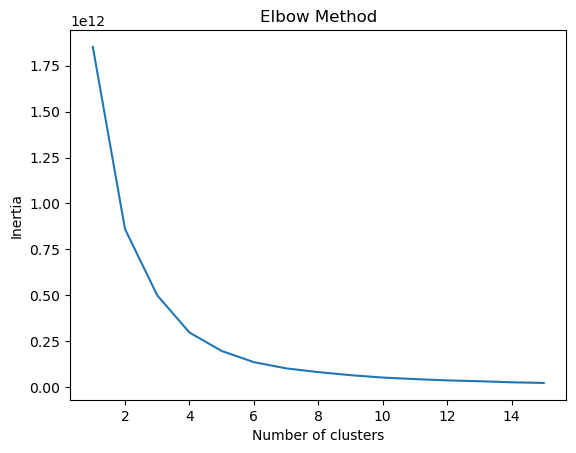

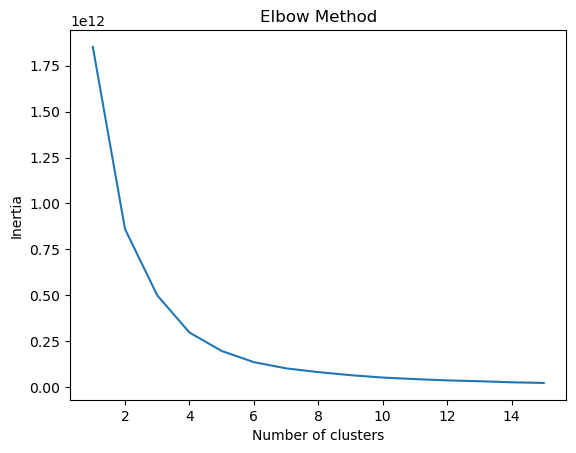

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

elbow = []

# Assuming 'train_df' is your dataset (replace with your actual dataset)
for x in range(1, 16):
    model = KMeans(n_clusters=x)
    model.fit(train_df)  # Fit the model to your dataset
    elbow.append(model.inertia_)  # Append inertia to the list

# Plotting the Elbow graph
plt.plot(range(1, 16), elbow)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [17]:
greatestSil = 0
for x in range(2, 10):
    model = KMeans(n_clusters=x)
    model.fit(train_df)
    
    if silhouette_score(train_df, model.labels_) > greatestSil:
        greatestSil = silhouette_score(train_df, model.labels_)
        bestCluster = x
        

In [18]:
greatestSil

0.5769486908849768

0.5769486908849768

In [19]:
bestCluster

2

2